# pulse2percept: Example Usage

This notebook illustrates a simple used-case of the software.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pulse2percept as p2p

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-26 17:18:02,578 [pulse2percept] [INFO] Welcome to pulse2percept


## 1. Setting up the Simulation

### 1.1 Setting up the Implant

All retinal implants live in the `implants` module.

You can either create your own `p2p.implants.ElectrodeArray`, or choose from one of the pre-defined types:

- `p2p.implants.ArgusI`: The A16 array has 16 electrodes arranged in a 4x4 grid.
  Electrodes are 800um apart and either 260um or 520um in diameter.
- `p2p.implants.ArgusII`: The A60 array has 60 electrodes arranged in a 6x10 grid.
  Electrodes are 525um apart and 200um in diameter.

If you are running this code in a Jupyter Notebook, you can see what arguments these objects take by starting to type the object's name, then hitting <tt>Shift+TAB</tt>:

    argus = p2p.implants.ArgusII(Shift+TAB
    
If you want to see more of the documentation, hit <tt>TAB</tt> again while still holding down <tt>Shift</tt> (so it's <tt>Shift+TAB+TAB</tt>).

In [2]:
# Load an Argus II array
argus = p2p.implants.ArgusI(x_center=-800, y_center=-400, h=0, rot=np.deg2rad(-35), eye='RE')

### 1.2 Starting the Simulation Framework

All simulations revolve around the `p2p.Simulation` object, which starts a new simulation framework.
Once an implant `argus` has been passed, it cannot be changed.

You can also specify on which backend to run the simulation via `engine`:

- `'serial'`: Run a single-thread computation.
- `'joblib'`: Use JobLib for paralellization. Specify the number of jobs via `n_jobs`.
- `'dask'`: Use Dask for parallelization. Specify the number of jobs via `n_jobs`

In [3]:
# Start the simulation framework
sim = p2p.Simulation(argus, engine='joblib')

### 1.3 Specifying the Retinal Model

The `p2p.Simulation` object allows you access every layer of the retinal model via setter functions:

- `set_optic_fiber_layer`: Specify parameters of the optic fiber layer (OFL), where the ganglion cell axons live.
- `set_ganglion_cell_layer`: Specify parameters of the ganglion cell layer (GCL), where the ganglion cell bodies live.
- `set_bipolar_cell_layer`: Coming soon.

In `set_optic_fiber_layer`, you can specify parameters such as the spatial sampling rate (`s_sample` in microns), or the dimensions of the retinal grid to simulate:

In [4]:
# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.

# Set the spatial sampling step (microns) of the retinal grid
s_sample = 100
sim.set_optic_fiber_layer(sampling=s_sample, n_axons=501, n_rho=801, rho_range=(4, 45),
                          sensitivity_rule='decay', decay_const=5.0,
                          contribution_rule='max')

2018-03-26 17:18:02,706 [pulse2percept.retina] [INFO] Loading file "./retina_RE_s100_a501_r801_4500x5000.npz".


In `set_ganglion_cell_layer`, you can choose from one of the available ganglion cell models:
- `'latest'`: The latest ganglion cell model for epiretinal and subretinal devices (experimental).
- `'Nanduri2012'`: A model of temporal sensitivity as described in Nanduri et al. (IOVS, 2012).
- `'Horsager2009'`: A model of temporal sensitivity as described in Horsager et al. (IOVS, 2009).

You can also create your own custom model (see [0.3-add-your-own-model.ipynb](0.3-add-your-own-model.ipynb)).

In [5]:
# Set parameters of the ganglion cell layer (GCL)
# In previous versions of the model, this used to be called `TemporalModel`.

# Set the temporal sampling step (seconds)
t_sample = 0.01 / 1000
sim.set_ganglion_cell_layer('Nanduri2012', tsample=t_sample)

### 1.4 Specifying the input stimulus

All stimulation protocols live in `p2p.stimuli`. You can choose from the following:

- `MonophasicPulse`: A single monophasic pulse of either cathodic (negative) or anodic (positive) current.
- `BiphasicPulse`: A single biphasic pulse going either cathodic-first or anodic-first.
- `PulseTrain`: A pulse train made from individual biphasic pulses with a specific amplitude, frequency, and duration.
- `image2pulsetrain`: Converts an image to a series of pulse trains (pixel-by-pixel).
- `video2pulsetrain`: Converts a video to a series of pulse trains (pixel-by-pixel).

In [6]:
# Send a pulse train to two specific electrodes, set all others to zero
stim = {
    'C1': p2p.stimuli.PulseTrain(t_sample, freq=50, amp=20, dur=0.5), 
    'B3': p2p.stimuli.PulseTrain(t_sample, freq=50, amp=20, dur=0.5)
}

We can visualize the specified electrode array and its location on the retina with respect to the optic disc:

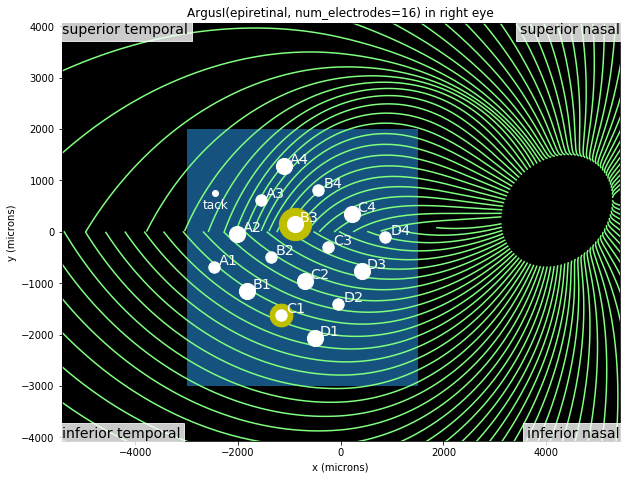

In [7]:
sim.plot_fundus(stim, upside_down=False);

# 2. Running the Simulation

Simulations are run by passing an input stimulus `stim` to `p2p.pulse2percept`. Output is a `p2p.utils.TimeSeries` objects that contains the brightness changes over time for each pixel.

In [8]:
# Run a simulation
# - tol: ignore pixels whose efficient current is smaller than 10% of the max
# - layers: simulate ganglion cell layer (GCL) and optic fiber layer (OFL),
#   but ignore inner nuclear layer (INL) for now
percept = sim.pulse2percept(stim, tol=0.1, layers=['GCL', 'OFL'])

2018-03-26 17:18:03,656 [pulse2percept.api] [INFO] Starting pulse2percept...
2018-03-26 17:18:08,693 [pulse2percept.api] [INFO] tol=10.0%, 1974/2346 px selected
2018-03-26 17:21:59,150 [pulse2percept.api] [INFO] Done.


# 3. Analyzing Output

You can look at the brightness time course of every pixel, or you can simply plot the brightest frame in the whole brightness "movie":

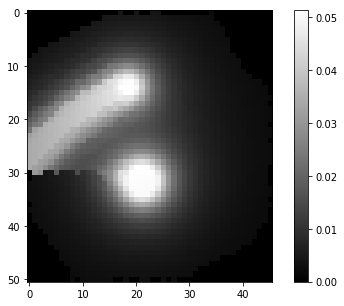

In [9]:
frame = p2p.get_brightest_frame(percept)
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='gray')
plt.colorbar()

Finally, you can also dump the percept to file, by creating MP4 or MOV videos (requires Scikit-Video).

In [10]:
# This requires ffmpeg or libav-tools
p2p.files.save_video(percept, 'percept.mp4', fps=30)

2018-03-26 17:22:06,241 [pulse2percept.files] [INFO] Saved video to file 'percept.mp4'.
